---
# Part 1, Figure 6: 
2018 Oil Cargo Transfers by Vessel Type and Volume

This notebook visualizes 2018 cargo oil transfers to (import) and from (export) Washington State marine terminals, by cargo vessel type and oil type. 

---

## Environment Setup

Install required packages using the provided environment file:
```bash
conda env create -f ../environment.yaml
conda activate midoss_env
```

*Ensure the dataset and code repositories are in the same root folder:*
```
root_folder/
├── MuellerEtAl_MIDOSS_datasets/
└── MuellerEtAl_MIDOSS_code/   # (this repository)
```

`MuellerEtAl_MIDOSS_datasets` is the companion [FRDR data repository](https://doi.org/10.20383/103.01353)


In [1]:
# --- Imports and Style ---
import pandas as pd
import numpy as np
import xarray
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm

# Set graphics style and load custom functions
plt.style.use("../style_templates/MuellerEtAl_matplotlibrc.template")
import sys
sys.path.insert(0, '../scripts')
import manuscript_setup as oil
from monte_carlo_utils import get_ECY_quantity_byfac, get_ECY_df, get_ECY_oilclassification, assign_facility_region

# Conversion factor
GAL2LITER = 3.78541

In [2]:
# --- Data Paths and Input Files ---
graphics_dir = Path('../')
spreadsheet_dir = Path('../../MuellerEtAl_MIDOSS_datasets/spreadsheets')
yaml_input_dir = Path('../../MuellerEtAl_MIDOSS_datasets/oil_attribution_yaml_files')

ecy_data_file = spreadsheet_dir/'MuellerTrans4-30-20.xlsx'
fac_names_file = spreadsheet_dir/'Oil_Transfer_Facilities.xlsx'
oil_attribution_file = yaml_input_dir/'oil_attribution.yaml'

# Load oil attribution YAML
with open(oil_attribution_file) as f:
    oil_attrs = yaml.load(f, Loader=yaml.Loader)

In [3]:
# --- Analysis Parameters ---
vessel_types = ['atb', 'barge', 'tanker']
oil_types = oil.types
data_types = ['total_gallons', 'fraction_of_total', 'number_of_transfers']

## 1. Imports and Exports by Vessel Type

We first calculate total import and export oil volumes by vessel type and oil type.

In [4]:
# Get oil transfer quantities by vessel/facility
exports, imports, combined = get_ECY_quantity_byfac(
    ecy_data_file,
    fac_names_file,
    facilities='selected'
)

get_ECY_quantity_byfac: not yet tested with fac_xls as input
Tallying atb quantities
Tallying barge quantities
Tallying tanker quantities


### a. Pie Charts: Imports and Exports by Vessel Type (Liters)

Each pie shows the relative proportions of oil types for imports and exports by vessel class (ATB, barge, tanker), with total volume in million liters.

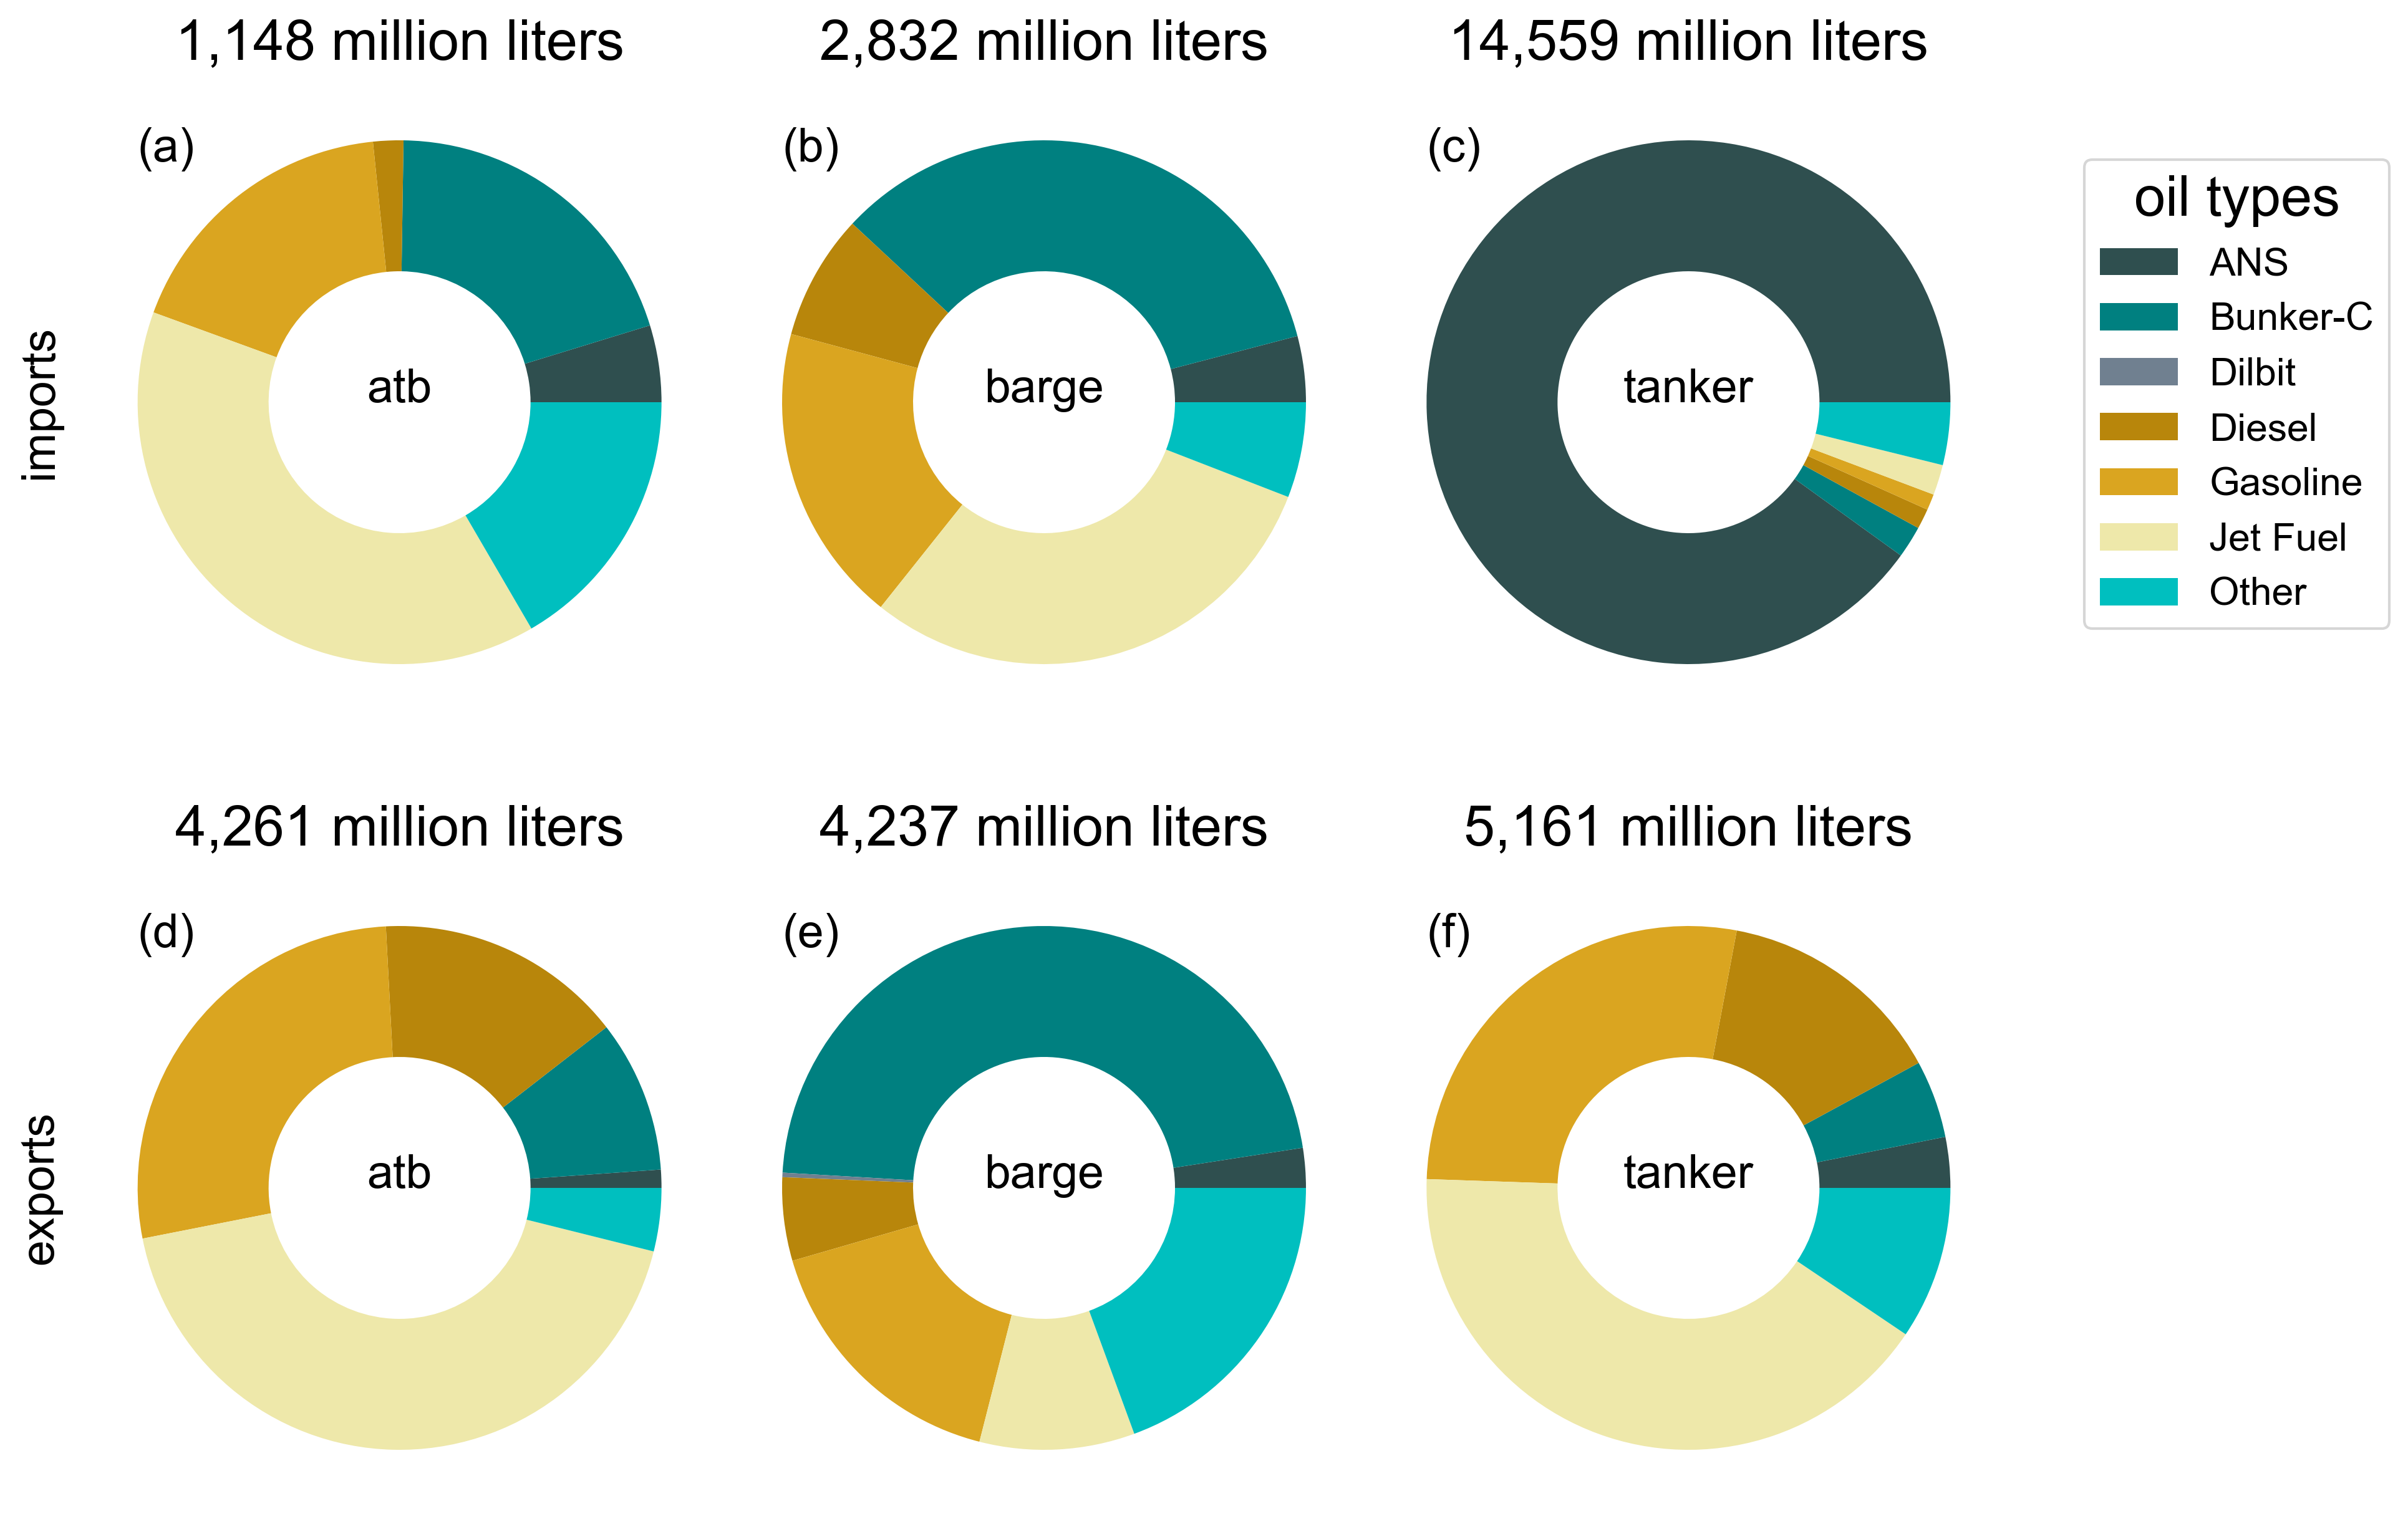

In [5]:
nc = 3  # number of vessel types / columns
fig = plt.figure(figsize=(20, 10))
spec = gridspec.GridSpec(ncols=nc, nrows=2, wspace=-.6, hspace=0.2)
axes = [fig.add_subplot(spec[i]) for i in range(nc*2)]
#plt.rcParams['axes.titlepad'] = -18

for j, vessel in enumerate(vessel_types):
    plot_imports = np.array(list(imports[vessel].values()))
    plot_exports = np.array(list(exports[vessel].values()))
    # Imports
    axes[j].pie(plot_imports, wedgeprops=dict(width=0.5), labels=None, colors=oil.colors7)
    axes[j].set_title(f'{GAL2LITER*plot_imports.sum()/1e6:,.0f} million liters')
    axes[j].text(0, 0, vessel, ha='center')
    # Exports
    axes[j+nc].pie(plot_exports, wedgeprops=dict(width=0.5), labels=None, colors=oil.colors7)
    axes[j+nc].set_title(f'{GAL2LITER*plot_exports.sum()/1e6:,.0f} million liters')
    axes[j+nc].text(0, 0, vessel, ha='center')

axes[0].set_ylabel('imports')
axes[nc].set_ylabel('exports')
for k, label in enumerate(['(a)','(b)','(c)','(d)','(e)','(f)']):
    axes[k].text(-1,0.92,label)
axes[2].legend(bbox_to_anchor=(1.6, 0.9), title='oil types', labels=oil.labels)

plt.savefig(graphics_dir/'Part1_Figure6a_oil_distribution_liters.png', dpi=600)
#plt.close()

### b. Pie Charts: Imports and Exports by Vessel Type (Gallons)

Same as previous, but total volumes shown in million gallons.

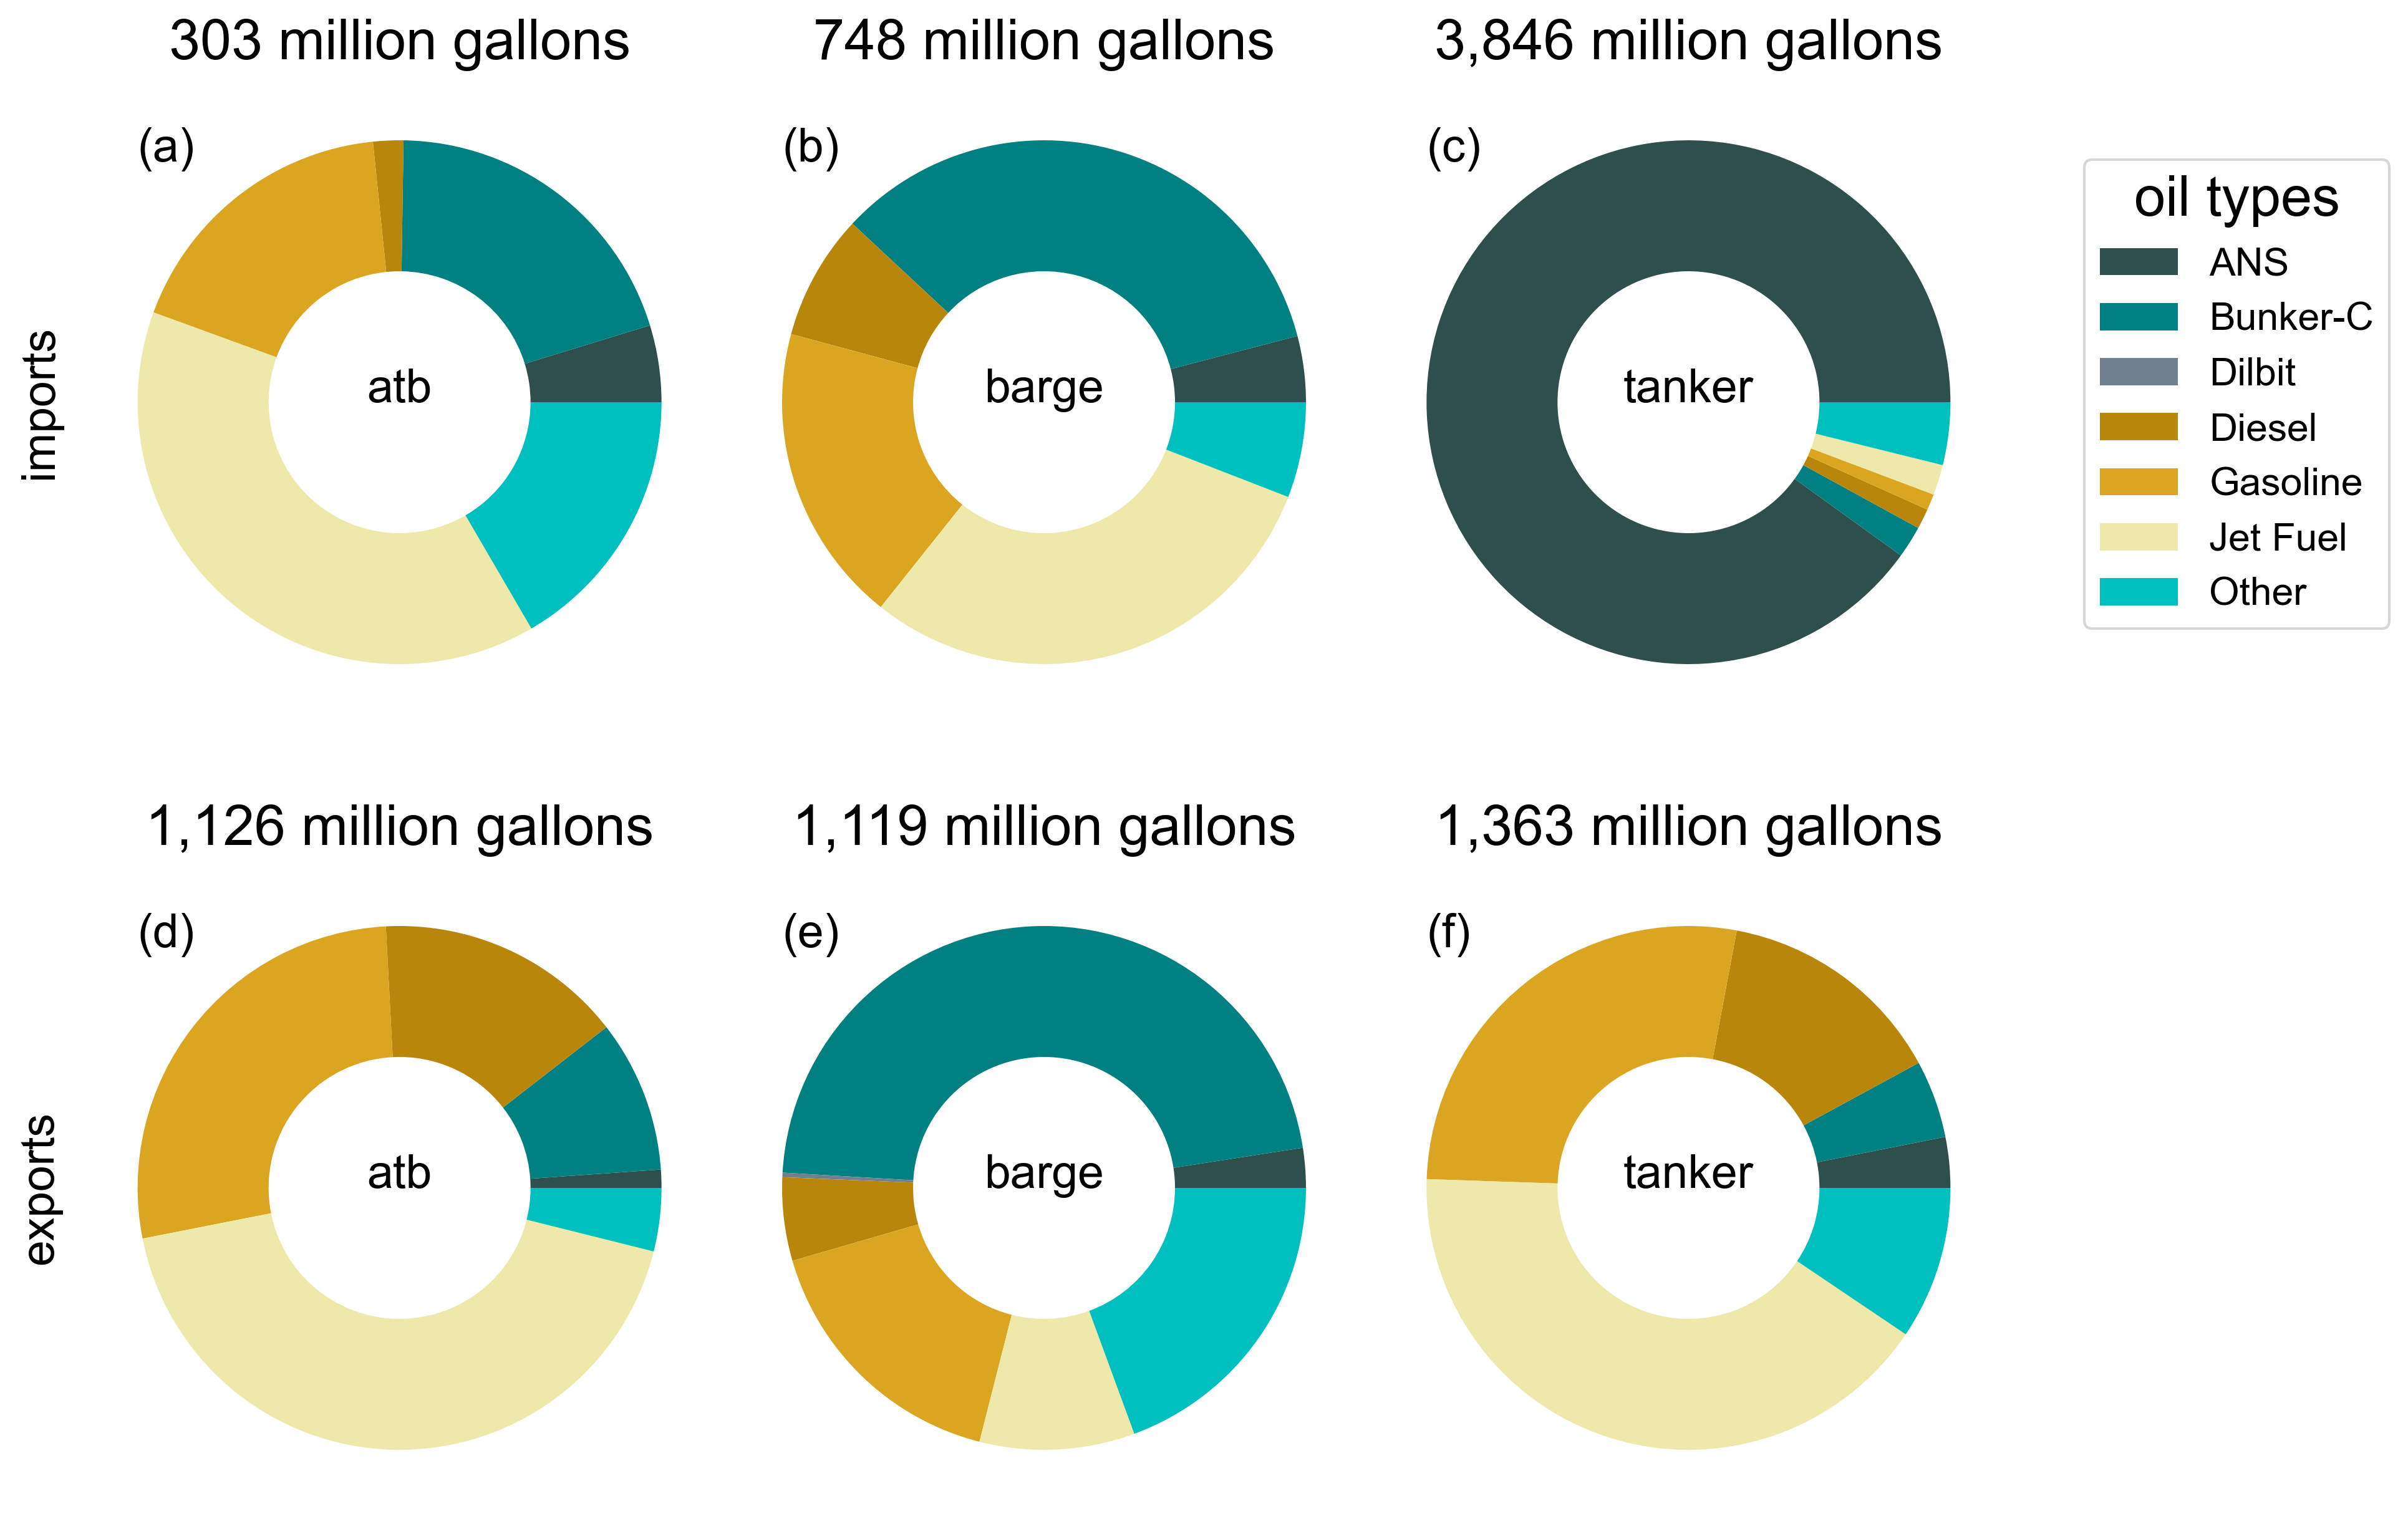

In [6]:
fig = plt.figure(figsize=(20, 10))
spec = gridspec.GridSpec(ncols=nc, nrows=2, wspace=-.6, hspace=0.2)
axes = [fig.add_subplot(spec[i]) for i in range(nc*2)]

for j, vessel in enumerate(vessel_types):
    plot_imports = np.array(list(imports[vessel].values()))
    plot_exports = np.array(list(exports[vessel].values()))
    axes[j].pie(plot_imports, wedgeprops=dict(width=0.5), labels=None, colors=oil.colors7)
    axes[j].set_title(f'{plot_imports.sum()/1e6:,.0f} million gallons')
    axes[j].text(0, 0, vessel, ha='center')
    axes[j+nc].pie(plot_exports, wedgeprops=dict(width=0.5), labels=None, colors=oil.colors7)
    axes[j+nc].set_title(f'{plot_exports.sum()/1e6:,.0f} million gallons')
    axes[j+nc].text(0, 0, vessel, ha='center')

axes[0].set_ylabel('imports')
axes[nc].set_ylabel('exports')
for k, label in enumerate(['(a)','(b)','(c)','(d)','(e)','(f)']):
    axes[k].text(-1,0.92,label)
axes[2].legend(bbox_to_anchor=(1.6, 0.9), title='oil types', labels=oil.labels)

plt.savefig(graphics_dir/'Part1_Figure6a_oil_distribution_gallons.png', dpi=600)
#plt.close()

---
## 2. Regional Oil Transfer Map

This map shows the regional distribution of oil imports/exports by oil type for major terminal regions in Washington: Whatcom County, Anacortes, and Puget Sound. Pie charts summarize the combined (import + export) oil type volumes for each region.

In [7]:
# --- Load geospatial fields and assign regions to facilities ---
georef = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV21-08")
mesh_mask = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV21-08")
water_mask = mesh_mask.tmaskutil.isel(time=0)
fields = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DPhysicsFields1hV21-11")
salinity = fields.salinity.sel(time="2020-08-14 14:30", depth=0, method="nearest").where(water_mask)

# Regional bins and tags
regions = ['Columbia River','Puget Sound','Anacortes','Whatcom County']

# Assign region to each facility
fac_df = assign_facility_region(fac_names_file)
fac_df.loc[fac_df['FacilityName']=='Tesoro Port Angeles Terminal', 'Region'] = 'None'
whatcom_fac_df    = fac_df[fac_df['Region']=='Whatcom County']
anacortes_fac_df  = fac_df[fac_df['Region']=='Anacortes']
pugetsound_fac_df = fac_df[fac_df['Region']=='Puget Sound']

In [8]:
# --- Aggregate oil transfer data by region and oil type ---
ECY_df = get_ECY_df(ecy_data_file, fac_names_file, group='no')
oil_classification = get_ECY_oilclassification(ecy_data_file)
type_description = ['TANK BARGE','TUGBOAT','TANK SHIP']
facility_names = oil_attrs['categories']['US_origin_destination']

exports_byOil = {}
imports_byOil = {}
for oil_type in oil.types:
    exports_byOil[oil_type] = ECY_df.loc[
        (ECY_df.TransferType == 'Cargo') &
        (ECY_df.ReceiverTypeDescription.isin(type_description)) & 
        (ECY_df.Deliverer.isin(facility_names)) & 
        (ECY_df.Product.isin(oil_classification[oil_type])),
        ['TransferQtyInGallon', 'ExportRegion']
    ].groupby('ExportRegion').sum()
    imports_byOil[oil_type] = ECY_df.loc[
        (ECY_df.TransferType == 'Cargo') &
        (ECY_df.DelivererTypeDescription.isin(type_description)) & 
        (ECY_df.Receiver.isin(facility_names)) & 
        (ECY_df.Product.isin(oil_classification[oil_type])),
        ['TransferQtyInGallon', 'ImportRegion']
    ].groupby('ImportRegion').sum()

exports_byRegion = {}
imports_byRegion = {}
combined_byRegion = {}
for region in regions:
    e = []
    i = []
    for oil_type in oil.types:
        e.append(exports_byOil[oil_type]['TransferQtyInGallon'].get(region,0))
        i.append(imports_byOil[oil_type]['TransferQtyInGallon'].get(region,0))
    imports_byRegion[region] = pd.DataFrame(np.asarray(i), columns=['Volume'], index=oil.types)
    exports_byRegion[region] = pd.DataFrame(np.asarray(e), columns=['Volume'], index=oil.types)
    combined_byRegion[region] = imports_byRegion[region] + exports_byRegion[region]

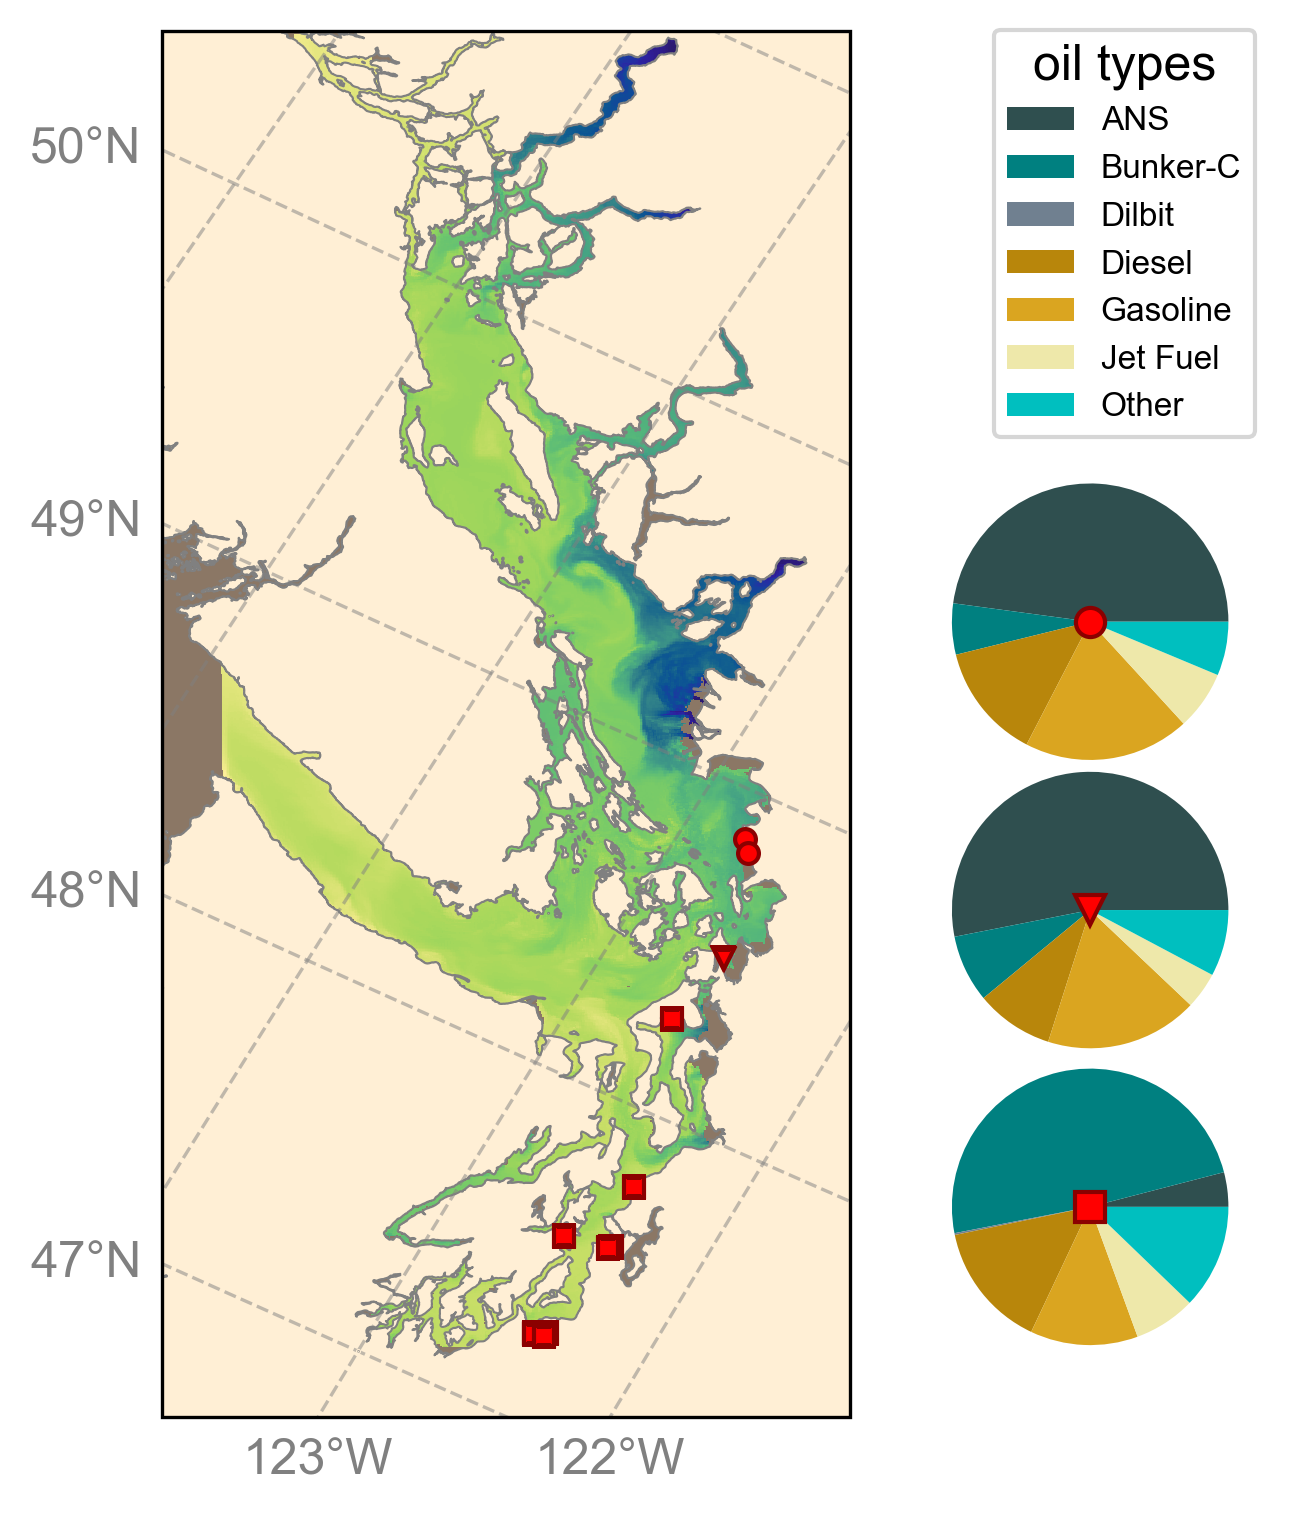

In [10]:
# ---- Parameters ----
REGION_LAT = {
    'whatcom': 48.88,
    'anacortes': 48.2,
    'puget': 47.5,
}
LON_REF = -122.758

# Offsets for pie chart placement (relative to lower left)
X_OFFSET = -0.09
Y_OFFSET = -0.044

# Plotting/CRS
rotated_crs = ccrs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
plain_crs = ccrs.PlateCarree()

# ---- Create Figure and Axes ----
fig, ax = plt.subplots(
    figsize=(12, 6),
    subplot_kw={"projection": rotated_crs, "facecolor": "#8b7765"}
)

# Add coastline feature
ax.add_feature(
    cfeature.GSHHSFeature(
        'full', edgecolor='grey', linewidth=0.5, facecolor='papayawhip'
    )
)

# ---- Salinity Mesh ----
quad_mesh = ax.pcolormesh(
    georef.longitude, georef.latitude,
    salinity, transform=plain_crs,
    cmap=cmocean.cm.haline, shading="auto"
)

# ---- Gridlines ----
gl = ax.gridlines(
    linestyle="--", color='gray', alpha=0.5, draw_labels=True, dms=True,
    x_inline=False, y_inline=False
)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator([-126, -125, -124, -123, -122])
gl.ylocator = mticker.FixedLocator([47, 48, 49, 50, 51])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12, 'color': 'gray'}
gl.ylabel_style = {'size': 12, 'color': 'gray'}

# ---- Helper: Pie inset axes ----
def add_region_pie(region, data, colorlist):
    """Add a pie chart inset for a region."""
    # Normalized location within the main axes
    x_frac = ((LON_REF - georef.longitude.min()) /
              (georef.longitude.max() - georef.longitude.min())).values.item()
    y_frac = ((REGION_LAT[region] - georef.latitude.min()) /
              (georef.latitude.max() - georef.latitude.min())).values.item()
    ax_inset = fig.add_axes([x_frac + X_OFFSET, y_frac + Y_OFFSET, .08 * 1.2, .2 * 1.2])
    ax_inset.pie(data, colors=colorlist)
    return ax_inset

# ---- Add Pie Charts for Each Region ----
ax_whatcom = add_region_pie('whatcom', combined_byRegion['Whatcom County']['Volume'], oil.colors7)
ax_puget = add_region_pie('puget', combined_byRegion['Puget Sound']['Volume'], oil.colors7)
ax_anacortes = add_region_pie('anacortes', combined_byRegion['Anacortes']['Volume'], oil.colors7)

# ---- Legend ----
plt.rcParams['legend.title_fontsize'] = '12' #titlesize needs to be reset for some reason
fig.legend(
    bbox_to_anchor=(.725, .89),
    title='oil types',
    prop={'size': 8},
    labels=oil.labels,
)

# ---- Workaround for setting extent ----
# (adds two nearly-invisible points to force the map extent)
ax.plot(-123, 47, '.', color='papayawhip', markersize=.5, transform=plain_crs)
ax.plot(-124.9, 48.5, '.', color="#8b7765", markersize=.5, transform=plain_crs)

# ---- Marker plotting ----
def plot_terminal(ax, df, marker, color, edgecolor, size, crs):
    """Scatter plot terminal locations."""
    ax.plot(
        df.DockLongNumber,
        df.DockLatNumber,
        marker,
        color=color,
        markeredgecolor=edgecolor,
        markersize=size,
        transform=crs
    )

marker_color = "red"
markeredge_color = 'darkred'

# Main map markers
plot_terminal(ax, whatcom_fac_df, 'o', marker_color, markeredge_color, 5, plain_crs)
plot_terminal(ax, pugetsound_fac_df, 's', marker_color, markeredge_color, 5, plain_crs)
plot_terminal(ax, anacortes_fac_df, 'v', marker_color, markeredge_color, 5, plain_crs)
# Pie insets (legend only)
ax_whatcom.plot(0, 0, 'o', color=marker_color, markeredgecolor=markeredge_color, markersize=7)
ax_puget.plot(0, 0, 's', color=marker_color, markeredgecolor=markeredge_color, markersize=7)
ax_anacortes.plot(0, 0, 'v', color=marker_color, markeredgecolor=markeredge_color, markersize=7)

plt.savefig(graphics_dir/'Part1_Figure6b_oil_distribution.png', dpi=600)

## 3. Facility Listings by Region
For reference, here are the marine terminal facilities by region:

In [11]:
whatcom_fac_df['FacilityName'].to_list()

['BP Cherry Point Refinery', 'Phillips 66 Ferndale Refinery']

In [12]:
anacortes_fac_df['FacilityName'].to_list()

['Shell Puget Sound Refinery', 'Marathon Anacortes Refinery (formerly Tesoro)']

In [13]:
pugetsound_fac_df['FacilityName'].to_list()

['Shell Oil LP Seattle Distribution Terminal',
 'Maxum Petroleum - Harbor Island Terminal',
 'Nustar Energy Tacoma',
 'SeaPort Sound Terminal',
 'Phillips 66 Tacoma Terminal',
 'U.S. Oil & Refining',
 'Naval Air Station Whidbey Island (NASWI)',
 'NAVSUP Manchester',
 'Alon Asphalt Company (Paramount Petroleum)',
 'Kinder Morgan Liquids Terminal - Harbor Island',
 'TLP Management Services LLC (TMS)']